**Proyecto: Pronóstico del dolar con el algoritmo de previsión DeepAR AWS**

Universidad Sergio Arboleda

Electiva 3 - Maestría en IA

Edwar A. Hernández

### Ajustes iniciales

#### Cargue de librerías requeridas

In [2]:
%matplotlib inline

import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

#### Ajuste de semillas para reproducibilidad de resultados

In [3]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [4]:
sagemaker_session = sagemaker.Session()

In [50]:
s3_bucket = "pronostico-dolar-04-2023"  # reemplazar con un bucket existente si es necesario
s3_prefix = "deepar-dolar-notebook"  # prefijo utilizado para todos los datos almacenados en el bucket

role = sagemaker.get_execution_role() # 'arn:aws:iam::503179242072:role/LabRole' IAM role usado por SageMaker

In [48]:
region = sagemaker_session.boto_region_name

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix) #Configuración path carpeta datos de entrada
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix) #Configuración path carpeta datos de salida

#### Configuración de imagen del contenedor

In [7]:
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", region)

#### EDA y ajustes iniciales del dataset

In [8]:
FILE_NAME = "Serie_historica_dolar_Deep_AR.csv"

In [9]:
data = pd.read_csv(FILE_NAME, index_col=0, parse_dates=True, dayfirst=True)

In [10]:
data.head()

,target
start,
2022-04-10,3777.41
2022-04-11,3777.41
2022-04-12,3744.16
2022-04-13,3736.70
2022-04-14,3737.32


In [11]:
timeseries = data.iloc[:, 0]

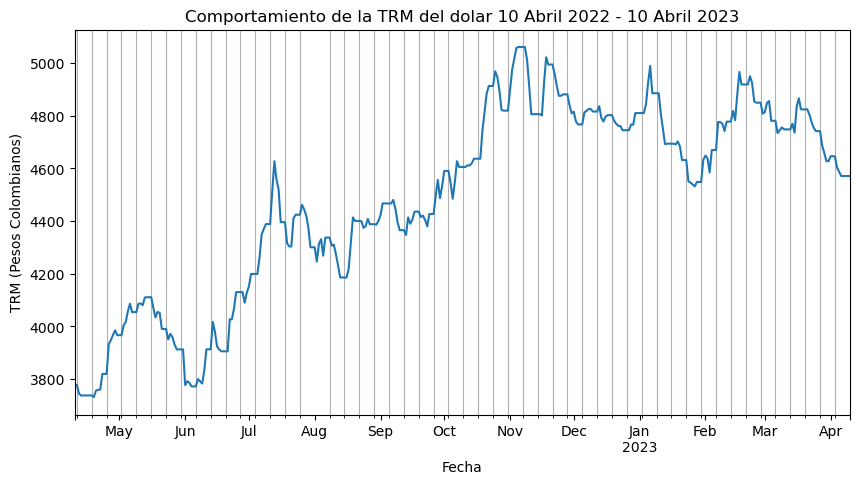

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
timeseries.plot(ax=ax)
ax.set_title("Comportamiento de la TRM del dolar 10 Abril 2022 - 10 Abril 2023")
ax.set_xlabel("Fecha")
ax.set_ylabel("TRM (Pesos Colombianos)")
ax.grid(which="minor", axis="x")

#### Partición Train y Test

El modelo de pronóstico busca realizar la predicción del valor de la TRM del dolar para el siguiente día, aplicando el algoritmo DeepAR, teniendo en cuenta que el valor a predecir solo consiste en uno (1), que corresponde a la TRM del siguiente día, la cantidad de datos en test será pequeña (2 semanas) y busca hacer una validación walk-forward del modelo, adicionalmente se considera que de acuerdo con las recomendaciones de AWS para utilizar este algortimo se debe utilizar como minimo 300 datos, por tanto este es el tamaño minimo del paquete de entrenamiento.

In [13]:
# usamos una frecuencia de 1 día para la serie de tiempo
freq = "1D"

# predecimos 1 día
prediction_length = 1

# también usamos 7 días como duración del contexto, esta es la cantidad de actualizaciones de estado realizadas antes de hacer predicciones
context_length = 7

In [14]:
start_dataset = pd.Timestamp("2022-04-10 00:00:00") # Fecha inicial del dataset
end_training = pd.Timestamp("2023-03-27 00:00:00") # Fecha final del dataset

Se crea un archivo json de entrenamiento de acuerdo con la forma en la que lo entiende el algoritmo DeepAR de AWS

In [23]:
training_data = [{
    "start": str(start_dataset),
    "target": timeseries[start_dataset : end_training].tolist()
}]
print(len(training_data))

1


Los datos de prueba se usarán para calcular las metricas de prueba, usando el modelo entrenado para pronosticar 1 día a las vez y comparar las predicciones con los valores reales. Para evaluar el rendimiento de nuestro modelo en más de un (1) día, generamos datos de prueba que se extienden a 15 días más allá del rango de entrenamiento. De esta manera realizamos una evaluación continua de nuestro modelo.

In [19]:
num_test_windows = 14

test_data = [{
        "start": str(start_dataset),
        "target": timeseries[start_dataset : end_training + timedelta(days=k * prediction_length)].tolist(),
    }
    for k in range(1, num_test_windows + 1)]

print(len(test_data))

14


#### Escritura de archivos json y envío a s3

In [24]:
def write_dicts_to_file(path, data):
    with open(path, "wb") as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode("utf-8"))

In [25]:
%%time
write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)

CPU times: user 3.86 ms, sys: 41 µs, total: 3.9 ms
Wall time: 4.78 ms


In [26]:
# Envío de archivos a S3

s3 = boto3.resource("s3")


def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith("s3://")
    split = s3_path.split("/")
    bucket = split[2]
    path = "/".join(split[3:])
    buk = s3.Bucket(bucket)

    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print(
                "File s3://{}/{} already exists.\nSet override to upload anyway.\n".format(
                    s3_bucket, s3_path
                )
            )
            return
        else:
            print("Overwriting existing file")
    with open(local_file, "rb") as data:
        print("Uploading file to {}".format(s3_path))
        buk.put_object(Key=path, Body=data)

In [34]:
%%time
copy_to_s3("train.json", s3_data_path + "/train/train.json")
copy_to_s3("test.json", s3_data_path + "/test/test.json")

Uploading file to s3://pronostico-dolar-04-2023/deepar-dolar-notebook/data/train/train.json
Uploading file to s3://pronostico-dolar-04-2023/deepar-dolar-notebook/data/test/test.json
CPU times: user 66.8 ms, sys: 0 ns, total: 66.8 ms
Wall time: 328 ms


### Modelo de entrenamiento 

In [56]:
estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    base_job_name="deepar-dolar",
    output_path=s3_output_path,
)

In [57]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
}

In [58]:
estimator.set_hyperparameters(**hyperparameters)

In [59]:
%%time
data_channels = {"train": "{}/train/".format(s3_data_path), "test": "{}/test/".format(s3_data_path)}

estimator.fit(inputs=data_channels, wait=True)

INFO:sagemaker:Creating training-job with name: deepar-dolar-2023-04-09-23-05-44-553


2023-04-09 23:05:44 Starting - Starting the training job...
2023-04-09 23:06:14 Starting - Preparing the instances for training.........
2023-04-09 23:07:31 Downloading - Downloading input data...
2023-04-09 23:07:56 Training - Downloading the training image......
2023-04-09 23:08:52 Training - Training image download completed. Training in progress..Arguments: train
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[04/09/2023 23:09:13 INFO 139996980188992] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpu

### Creación de Endpoint y Predictor

In [60]:
from sagemaker.serializers import IdentitySerializer

 Esta clase (Creada en ejemplo de AWS para implementación del algoritmo) permite realizar solicitudes utilizando objetos pandas.Series en lugar de cadenas JSON sin procesar.

In [70]:
class DeepARPredictor(sagemaker.predictor.Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args,
            # serializer=JSONSerializer(),
            serializer=IdentitySerializer(content_type="application/json"),
            **kwargs,
        )

    def predict(
        self,
        ts,
        cat=None,
        dynamic_feat=None,
        num_samples=100,
        return_samples=False,
        quantiles=["0.1", "0.5", "0.9"],
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        ts.index.freq = 'D' # Establecer una frecuencia diaria
        prediction_time = ts.index[-1] + ts.index.freq
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)

    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(
            ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None
        )

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles,
        }

        http_request_data = {"instances": [instance], "configuration": configuration}

        return json.dumps(http_request_data).encode("utf-8")

    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode("utf-8"))["predictions"][0]
        prediction_length = len(next(iter(predictions["quantiles"].values())))
        prediction_index = pd.date_range(
            start=prediction_time, freq=freq, periods=prediction_length
        )
        if return_samples:
            dict_of_samples = {"sample_" + str(i): s for i, s in enumerate(predictions["samples"])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(
            data={**predictions["quantiles"], **dict_of_samples}, index=prediction_index
        )

    def set_frequency(self, freq):
        self.freq = freq


def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]


def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat
    return obj

In [71]:
predictor = estimator.deploy(
    initial_instance_count=1, instance_type="ml.m5.large", predictor_cls=DeepARPredictor
)

INFO:sagemaker:Creating model with name: deepar-dolar-2023-04-10-00-16-35-797
INFO:sagemaker:Creating endpoint-config with name deepar-dolar-2023-04-10-00-16-35-797
INFO:sagemaker:Creating endpoint with name deepar-dolar-2023-04-10-00-16-35-797


-----!

### Predicción para el día siguiente

In [73]:
predictor.predict(ts=timeseries, quantiles=[0.10, 0.5, 0.90]).head()

,0.1,0.5,0.9
2023-04-11,4516.992188,4592.122559,4655.128418


De acuerdo con lo anterior el valor más probable de la TRM del dolar con el con el modelo desplagado es $ 4592.122559